# Great Expectations tutorial
Welcome! In this tutorial we'll have a look at Great Expectations, a python library that aids you in keeping an eye on your data quality. It provides a batteries-included solution for testing and documenting your data, so that nobody has to run into any surprises when consuming it. To achieve this, you create _expectation suites_. You can think of them like unit tests, but for data. They also double as documentation for your dataset, so that you won't have to repeat yourself.

### What is Great Expectations exactly?

![in_out](figures/in_out.png?raw=true)

Great Expectations can be used with your existing data assets - it is able to run on different backends such as SQL databases, Spark clusters, or just your plain old filesystem. It will execute your expectation suites on these backends, and generate reports on the results of your validation. \
Writing your expectation suite is usually done through jupyter notebooks, so you'll feel at home. This notebook itself would be an example of how that works!


### In this tutorial
We'll give you a brief introduction to the main concepts used in Great Expectations, walking you through writing your first expectations and generating your first data report. We have added many references to the official documentation that you can reference to when you are configuring your own setup.

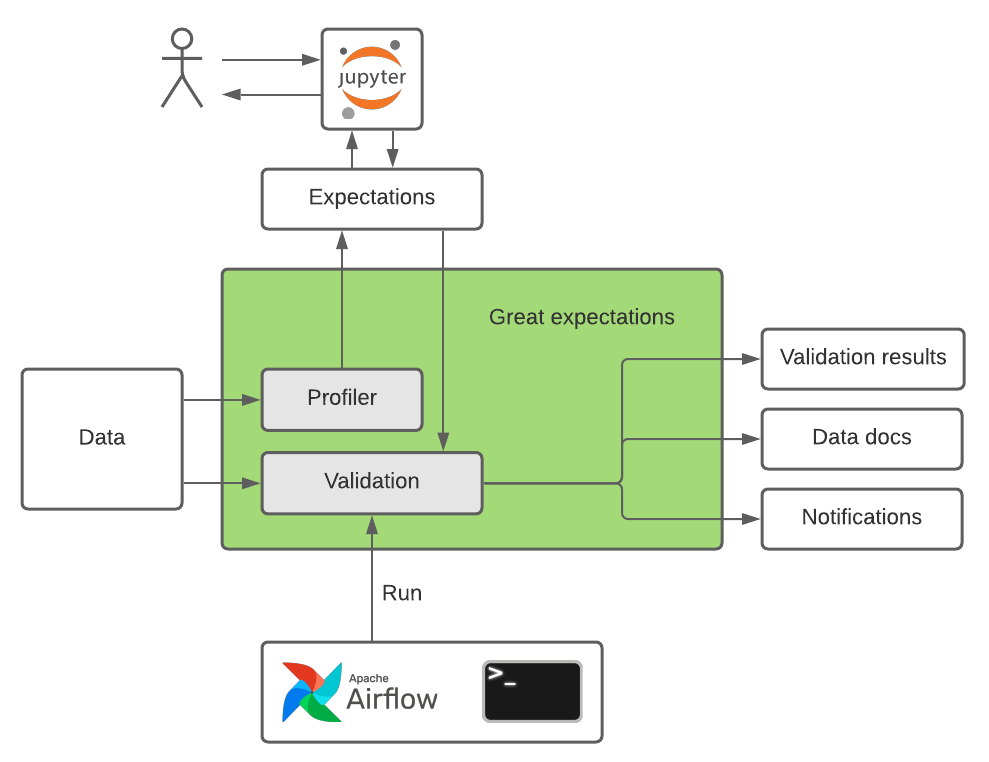

In [2]:
from IPython import display
display.Image("figures/in_out.png")

# Getting started

Let's jump into it then!

In [1]:
import great_expectations as ge

First we'll need a `DataContext`. This represents a Great Expectations project, holding all your configurations, expectation suites, data sources and so on. We'll have a better look at the data context later [[jump ahead]](#section-data-context), but just to get started we shipped a simple one with this tutorial.

We'll load that one right now. By default, Great Expectations will look for your configuration in the `great_expectations` directory.

In [2]:
context = ge.data_context.DataContext()

Now that we have our `DataContext` ready, we can add an expectation suite. Think of this like a test suite, but for your data instead of for your code. Usually you'll do this through the CLI, but we will get to that later [[jump ahead]](#section-cli). We'll name the suite `check_avocado_data`.

In [3]:
suite = context.create_expectation_suite(
    "check_avocado_data",
    overwrite_existing=True
)

Next, we load our dataset, `avocado.csv`, from our data context. This involves a bit of configuration, but don't worry about it too much for now. We'll get back to that later [TODO: when + link].

In [4]:
batch_kwargs = {
      'path': 'data/avocado.csv',
      'datasource': 'data_dir',
      'reader_method': 'read_csv',
      'data_asset_name': 'avocado',
}
batch = context.get_batch(batch_kwargs, suite)

Alright, that's it for setup!

Let's continue to our avocado sales data.

In [5]:
batch.head()

,Unnamed: 0,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


This is the documentation that came with the data:
 - Date - The date of the observation
 - AveragePrice - the average price of a single avocado
 - type - agriculture type: conventional or organic
 - Region - the city or region of the observation
 - Total Volume - Total number of avocados sold
 - 4046 - Total number of avocados with PLU 4046 sold (small Hass)
 - 4225 - Total number of avocados with PLU 4225 sold (large Hass)
 - 4770 - Total number of avocados with PLU 4770 sold (extra large Hass)
 
These descriptions sure help us to understand the dataset a bit better, but they don't exactly provide much guarantees. When consuming this dataset, what assumptions can we make? Will the `region` field always be specified? Will the `Date` field always be in the same format? Those sales counts, are they supposed to add up?

Great Expectations helps us to codify these properties in a set of `Expectations`. An `Expectation` is, well, something that you expect to be true in your data. Again, think of it like an unit test for your dataset.

Let's run a basic `Expectation` to get started. For example, we could check whether the `Date` column is present in our dataset.

In [6]:
batch.expect_column_to_exist('Date')

{
  "result": {},
  "success": true,
  "meta": {},
  "exception_info": {
    "raised_exception": false,
    "exception_traceback": null,
    "exception_message": null
  }
}

The resulting `dict` we got back might feel a bit weird at first, but you'll see later on how this output is used to generate reports [[jump ahead]](#section-data-docs). For now, just note that `success` has the value `true`, indicating that our expectation passed!

This was a simple check that only assesses the data shape, but doesn't touch the values in there (it is a _table-level check_).

Let's try adding a check for the values now. Maybe we can address one of the concerns we raised: can we add an `Expectation` that ensures every record will have its `region` specified?

In [7]:
batch.expect_column_values_to_not_be_null('region')

{
  "result": {
    "element_count": 18249,
    "unexpected_count": 0,
    "unexpected_percent": 0.0,
    "partial_unexpected_list": []
  },
  "success": true,
  "meta": {},
  "exception_info": {
    "raised_exception": false,
    "exception_traceback": null,
    "exception_message": null
  }
}

That worked! This time we got a bit more info back: the `result` section now contains some metrics about our data. We can see that all 18249 records passed the check, and there were no unexpected (i.e. `null`) values. If Great Expectations finds any offending values, they will be listed in the `partial_unexpected_list`.

Now let's do something that's a bit more strict. It would be nice, for example, to make sure that all `region`s are actually strings, so that we don't end up with numeric regions.

In [8]:
batch.expect_column_values_to_be_of_type('region', 'str')

{
  "result": {
    "element_count": 18249,
    "missing_count": 0,
    "missing_percent": 0.0,
    "unexpected_count": 0,
    "unexpected_percent": 0.0,
    "unexpected_percent_nonmissing": 0.0,
    "partial_unexpected_list": []
  },
  "success": true,
  "meta": {},
  "exception_info": {
    "raised_exception": false,
    "exception_traceback": null,
    "exception_message": null
  }
}

Note that metrics on the amount of missing values were still collected. This way, we can disambiguate between missing values and incorrect values. In case you were wondering, the `unexpected_percent_nonmissing` refers to the percentage of present (non-null) values that did not meet our expectation (they were not a string). If other metrics are unclear to you, check out [this documentation page](https://docs.greatexpectations.io/en/latest/reference/core_concepts/expectations/result_format.html#behavior-for-summary).

Now that we covered the basics, let's get to some fancier expectations. For example, we could make sure that all `Date`s are in the expected format:

In [9]:
batch.expect_column_values_to_match_strftime_format('Date', "%Y-%m-%d")

{
  "result": {
    "element_count": 18249,
    "missing_count": 0,
    "missing_percent": 0.0,
    "unexpected_count": 0,
    "unexpected_percent": 0.0,
    "unexpected_percent_nonmissing": 0.0,
    "partial_unexpected_list": []
  },
  "success": true,
  "meta": {},
  "exception_info": {
    "raised_exception": false,
    "exception_traceback": null,
    "exception_message": null
  }
}

Another example: we can make sure all the listed avocado prices are reasonable.

In [10]:
batch.expect_column_values_to_be_between('AveragePrice', min_value=0.5, max_value=3.0)

{
  "result": {
    "element_count": 18249,
    "missing_count": 0,
    "missing_percent": 0.0,
    "unexpected_count": 11,
    "unexpected_percent": 0.06027727546714888,
    "unexpected_percent_nonmissing": 0.06027727546714888,
    "partial_unexpected_list": [
      0.49,
      0.46,
      3.03,
      3.12,
      3.25,
      0.44,
      0.49,
      0.48,
      3.05,
      3.04,
      3.17
    ]
  },
  "success": false,
  "meta": {},
  "exception_info": {
    "raised_exception": false,
    "exception_traceback": null,
    "exception_message": null
  }
}

Oops! That failed. Looks like we have some outliers here! Great Expectations helpfully collected them for us. By default, it will collect up to 20 examples of values that didn't meet the expectation (that's why it's called the _partial_ unexpected list).

If we want to allow these outliers, we can add some tolerance to the check by using the `mostly` parameter. Let's settle for having 99% of avocados being priced within the range we specified.

In [11]:
batch.expect_column_values_to_be_between('AveragePrice', min_value=0.5, max_value=3.0, mostly=0.99)

{
  "result": {
    "element_count": 18249,
    "missing_count": 0,
    "missing_percent": 0.0,
    "unexpected_count": 11,
    "unexpected_percent": 0.06027727546714888,
    "unexpected_percent_nonmissing": 0.06027727546714888,
    "partial_unexpected_list": [
      0.49,
      0.46,
      3.03,
      3.12,
      3.25,
      0.44,
      0.49,
      0.48,
      3.05,
      3.04,
      3.17
    ]
  },
  "success": true,
  "meta": {},
  "exception_info": {
    "raised_exception": false,
    "exception_traceback": null,
    "exception_message": null
  }
}

Another common usecase would be when you only expect a certain set of values to show up in a column. This is the case for our `type` column, since we only know about `conventional` and `organic` grown avocados. Let's add a check for that:

In [12]:
batch.expect_column_distinct_values_to_be_in_set('type', ['conventional', 'organic'])

{
  "result": {
    "observed_value": [
      "conventional",
      "organic"
    ],
    "element_count": 18249,
    "missing_count": null,
    "missing_percent": null
  },
  "success": true,
  "meta": {},
  "exception_info": {
    "raised_exception": false,
    "exception_traceback": null,
    "exception_message": null
  }
}

We could even add a check on the value frequencies! For example, if we want the ratio of organic to conventional to be roughly equal, we could check the [Kullback-Leiber divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence) between our assumed distribution, and the one that is observed in the dataset.

In [13]:
partition_object = {
    'values': ['conventional', 'organic'],
    'weights': [0.5, 0.5],
    
}
batch.expect_column_kl_divergence_to_be_less_than('type', partition_object, 0.1)

{
  "result": {
    "observed_value": 1.351245850704074e-08,
    "element_count": 18249,
    "missing_count": null,
    "missing_percent": null
  },
  "success": true,
  "meta": {},
  "exception_info": {
    "raised_exception": false,
    "exception_traceback": null,
    "exception_message": null
  }
}

Now that we checked out some expectations, maybe try adding one yourself? You can check out the [glossary of expectations](https://docs.greatexpectations.io/en/latest/reference/glossary_of_expectations.html) for a complete list of what you can do. Go wild!

In [ ]:
# The stage is all yours

## The Expectation Suite

So, while we were experimenting up there, great_expectations remembered all the expectations we ran. We can now retrieve the suite contents as follows:

In [14]:
batch.get_expectation_suite()

{
  "data_asset_type": "Dataset",
  "expectations": [
    {
      "kwargs": {
        "column": "Date"
      },
      "expectation_type": "expect_column_to_exist",
      "meta": {}
    },
    {
      "kwargs": {
        "column": "region"
      },
      "expectation_type": "expect_column_values_to_not_be_null",
      "meta": {}
    },
    {
      "kwargs": {
        "column": "region",
        "type_": "str"
      },
      "expectation_type": "expect_column_values_to_be_of_type",
      "meta": {}
    },
    {
      "kwargs": {
        "column": "Date",
        "strftime_format": "%Y-%m-%d"
      },
      "expectation_type": "expect_column_values_to_match_strftime_format",
      "meta": {}
    },
    {
      "kwargs": {
        "column": "AveragePrice",
        "min_value": 0.5,
        "max_value": 3.0,
        "mostly": 0.99
      },
      "expectation_type": "expect_column_values_to_be_between",
      "meta": {}
    },
    {
      "kwargs": {
        "column": "type",
        "value_

That gave us the `dict` representation Great Expectations uses under the hood to keep track of our exepectation suite. Can you recognise some of the expectations we wrote?

This representation can then be saved to a file, so that we can load it again at another time, without depending on the python code that produced it.

Note that by default, expectations that failed on the `batch` we ran them against will be omitted. If you want to include them anyways, you could add the `discard_failed_expectations=False` parameter.

In [15]:
batch.save_expectation_suite()

An expectation suite is just a sequence of expectations, as shown below.

![expectation_suite](figures/expectation_suite.png)

Now let us get back to that configuration we mentioned earlier. As we said, it's just some files living in the `great_expectations` directory. This is what it looks like:

In [17]:
!tree great_expectations -I "uncommitted"

great_expectations
├── checkpoints
├── expectations
│   └── check_avocado_data.json
├── great_expectations.yml
├── notebooks
│   ├── pandas
│   │   └── validation_playground.ipynb
│   ├── spark
│   │   └── validation_playground.ipynb
│   └── sql
│       └── validation_playground.ipynb
└── plugins
    └── custom_data_docs
        ├── renderers
        ├── styles
        │   └── data_docs_custom_styles.css
        └── views

11 directories, 6 files


So, we have the main `great_expectations.yml` configuration file, a folder with checkpoints, a folder with expectation suites, some playground notebooks, and a folder for plugins. \
[TODO: would it be better to move this part on the configuration folder to the next section?]

As you can see, the `save_expectation_suite` command saved our `check_avocado_data` suite to the `expectations` folder! That's all there is to it, the expectation suite is just a file. It contains that same internal representation that we just retrieved. You can check if you like!

In [ ]:
!cat great_expectations/expectations/check_avocado_data.json

<a id="validation-results"></a>
Now that we added our expectation suite to our `DataContext`, we can try running the entire suite. This is done by applying a `ValidationOperator` to the suite and the dataset. `ValidationOperator`s for your project are defined in the `great_expectations.yml` file. We already provided a `ValidationOperator` called `action_list_operator` [TODO: would it be clearer to change this name to something more clear (it is the default name)?] which will run the expectation suite and record its results.

A validation operator is basically a sequence of actions that you'll execute when validating your data, as shown in the diagram below.
![validation_operator](figures/validation_operator.png)

In [22]:
results = context.run_validation_operator("action_list_operator", assets_to_validate=[batch])

We didn't specify our expectation suite for that command, but remember that the `batch` dataset kept track of our suite for us, so it will know what to do.

That produced a big datadump for us. Let's inspect it.

In [23]:
results

{
  "run_id": {
    "run_name": "20210119T111409.811156Z",
    "run_time": "2021-01-19T11:14:09.811156+00:00"
  },
  "run_results": {
    "ValidationResultIdentifier::check_avocado_data/20210119T111409.811156Z/20210119T111409.811156Z/a52e8a35d5f03815b708c7306612dbde": {
      "validation_result": {
        "results": [
          {
            "result": {},
            "expectation_config": {
              "kwargs": {
                "column": "Date",
                "result_format": {
                  "result_format": "SUMMARY"
                }
              },
              "expectation_type": "expect_column_to_exist",
              "meta": {}
            },
            "success": true,
            "meta": {},
            "exception_info": {
              "raised_exception": false,
              "exception_message": null,
              "exception_traceback": null
            }
          },
          {
            "result": {
              "element_count": 18249,
              "missi

This is called a *validation result*. Validation results are kept in the *validation store*, which is the `great_expectations/uncommitted/validations` directory by default.

In [24]:
!tree great_expectations/uncommitted/validations

great_expectations/uncommitted/validations
└── check_avocado_data
    └── 20210119T111409.811156Z
        └── 20210119T111409.811156Z
            └── a52e8a35d5f03815b708c7306612dbde.json

3 directories, 1 file


Great Expectations also allows you to set other backends as a validation store, such as an S3 bucket or a SQL database. Check out [metadata stores](https://docs.greatexpectations.io/en/latest/guides/how_to_guides/configuring_metadata_stores.html) if you would like to learn more!

<a id="section-data-docs"></a>
## Data Docs

We can render these results to a friendly report, called a data doc. These data docs will describe the expectations that the data should meet, as well as the metrics detailing how well the data meets the requirements. This is how Great Expectations combines testing with documenting. Running the code below will generate the data docs and open them in a new tab, make sure to have a look around. You'll see the code we ran above reflected in the different sections - it's pretty self-explanatory!

TODO: make sure these docs are in the repo, and add a link to them for online readers

In [25]:
context.build_data_docs()

# get the result identifier for our run
validation_result_identifier = list(results["run_results"].keys())[0]
context.open_data_docs(validation_result_identifier)

Note: we exracted that `validation_result_identifier` so we could bring you directly to the data doc for this validation result. When you're out there, you could just as well open the index and navigate to the result yourself.

Just like for validation results, different storage backends can be configured for your data docs. You could, for example, host them on an S3 bucket for easy viewing. Refer to [configuring data docs](https://docs.greatexpectations.io/en/latest/guides/how_to_guides/configuring_data_docs.html) for more information.

<a id="section-data-context"></a>
# Data Context

Before we move on, let's take a moment to look at the `DataContext`, which represents your Great Expectations setup. As we saw in the previous section, it consists of a directory with a `great_expectations.yml` file, which is the main configuration for your project. We won't focus on all the details here, you can refer to the [data context reference](https://docs.greatexpectations.io/en/latest/reference/spare_parts/data_context_reference.html) for that. Instead, we'll highlight some important concepts:

- A **data source** is something that can provide data to Great Expectations, such as an SQL database.
- A **data asset** is one dataset that lives in a *data source*, such as an SQL table.

In the configuration we provided, there is one *data source* named `data_dir`, which is just a folder with csv files inside. the `avocado.csv` file we are working with would be a *data asset*.
More information on data sources can be found in the [data context reference](https://docs.greatexpectations.io/en/latest/reference/spare_parts/data_context_reference.html#datasources).

- A **validation operator** specifies what should be done with your validations. Some examples could be writing the validation results to a database, publishing data docs, or sending a notification to a slack channel.
    If you'd like to know more you can check out the [validation operators and actions](https://docs.greatexpectations.io/en/latest/reference/core_concepts/validation_operators_and_actions.html) and [how to add a validation operator](https://docs.greatexpectations.io/en/latest/guides/how_to_guides/validation/how_to_add_a_validation_operator.html) documentation pages.


- **stores** specify where expectation and validation data will be stored. See [configuring metadata stores](https://docs.greatexpectations.io/en/latest/guides/how_to_guides/configuring_metadata_stores.html) if you're interested.

These are all configured in the `great_expectations.yml` file.

In addition to those, we still have two important directories:`expectations`, which holds our expectation suites, and `checkpoints`, which we'll check out now.

The diagram below shows a conceptual representation of a data context.

![data_context](figures/data_context.png)

# Checkpoints

To get started, we manually ran our expectation suite against our dataset. While that worked, there is a better way: checkpoints.

A checkpoint has three components:
- A *data asset* that will be validated
- *Expectation suites* to validate the data
- A *validation operator* to handle the validation

We can create a checkpoint by adding a file in the `checkpoints` directory of our great_expectations configuration.

In [26]:
%%writefile great_expectations/checkpoints/avocado_data.yml

validation_operator_name: action_list_operator
batches:
  - batch_kwargs:
      path: data/avocado.csv
      datasource: data_dir
      reader_method: read_csv
      data_asset_name: avocado
    expectation_suite_names:
      - check_avocado_data

Writing great_expectations/checkpoints/avocado_data.yml


`batches` is a list of (data batch, expectation suites) pairs. `batch_kwargs` specifies how the data asset should be loaded, you might recognise the parameters from earlier!

We created the file manually here for demonstration purposes, but when doing this in your own project you probably want to use the CLI [[jump ahead]](#section-cli), which will also help you in setting the right parameters. If you need to configure them further, try [creating batches](https://docs.greatexpectations.io/en/latest/guides/how_to_guides/creating_batches.html).

The checkpoint can be executed by using the great_expectations cli:

In [27]:
!great_expectations checkpoint run avocado_data

Heads up! This feature is Experimental. It may change. Please give us your feedback!
Validation succeeded!

Suite Name                                   Status     Expectations met
- check_avocado_data                         ✔ Passed   7 of 7 (100.0 %)


So, to summarize: a checkpoint is a _runnable check_ for your data. They are your first stop for integrating Great Expectations into your pipelines and workflows.
For more info on how to do that, refer to the [validation guides](https://docs.greatexpectations.io/en/latest/guides/how_to_guides/validation.html), or the [workflows and patterns](https://docs.greatexpectations.io/en/latest/guides/workflows_patterns.html) guides.

Checkpoints and batches are represented conceptually below.
![checkpoint](figures/checkpoint.png)
![batch](figures/batch.png)

# Profiling

In the previous sections we explored how we could get some metrics about our data using expectations. But what if you don't know what exactly to expect of your data? Well, you could try using Great Expectations' profiling feature, which can try to extract some useful metrics from your data. To try profiling our preconfigured `data_dir` data source, we can use the CLI:

In [ ]:
!great_expectations datasource profile data_dir -y

Running that command should have presented you with freshly built data docs. You can find the results in the `Profiling Results` tab. The profiler also generated an expectation suite based on its observations, which you can find in the `Expectation Suites` tab. Be mindful that this is an experimental feature and the generated suite is usually not that helpful, but it could be a good starting point for writing your own.


If you'd like to know more about profiling, the [profiling reference](https://docs.greatexpectations.io/en/latest/reference/spare_parts/profiling_reference.html) can help you out.

<a id="section-cli"></a>
# The Great Expectations CLI

For the purposes of this tutorial, we mostly interacted directly with Great Expectations. If you are going to set up and use Great Expectations for yourself, we recommend using the CLI as much as possible. The concepts should be familiar by now - refer to the  [CLI guide](https://docs.greatexpectations.io/en/latest/guides/how_to_guides/miscellaneous/command_line.html) for more.

In [28]:
!great_expectations --help

Usage: great_expectations [OPTIONS] COMMAND [ARGS]...

  Welcome to the great_expectations CLI!

  Most commands follow this format: great_expectations <NOUN> <VERB>

  The nouns are: datasource, docs, project, suite, validation-operator

  Most nouns accept the following verbs: new, list, edit

  In particular, the CLI supports the following special commands:

  - great_expectations init : create a new great_expectations project

  - great_expectations datasource profile : profile a datasource

  - great_expectations docs build : compile documentation from expectations

Options:
  --version      Show the version and exit.
  -v, --verbose  Set great_expectations to use verbose output.
  --help         Show this message and exit.

Commands:
  checkpoint           Checkpoint operations
  datasource           Datasource operations
  docs                 Data Docs operations
  init                 Initialize a new Great Expectations project.
  project              Project operations
  stor

## Next steps: setting up your own project

To initialize your own project, run `great_expectations init` and follow the instructions. This will scaffold a simple configuration for you, just like the one we provided. \
Once you created your suite using `great_expectations suite new`, you can use the `great_expectations suite edit` command to open up an auto-generated notebook that you can use to set up your suite. You should be able to recognise the structure of the first part of this notebook a bit ;-)

The [getting started guide](https://docs.greatexpectations.io/en/latest/guides/tutorials/getting_started.html) can  help you along the way.